# Introduction

This project seeks to build a binary classification model that can determine if a given search term is a part number or a keyword.

The following steps will be taken:
- Load the search term data
- Perform Exploratory Data Analysis (EDA) on the search term data
- Build the classification model
- Analyze the results
- Draw conclusions / plan future steps

# Load Data

In [36]:
# Uncomment and run the following lines to install the necessary packages on your machine if not already installed.
#!pip install -U scikit-learn
#!pip install -U pandas
#!pip install -U seaborn

In [1]:
# Load necessary packages
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
terms = pd.read_csv("search_terms.csv", dtype={'term': str})
terms.head() # display first five rows

,term,length,letterCount,numberCount,spaceCount,startsWithNumber,endsWithNumber,isPartNumber
0,ladc300113,10,4,6,0,0,1,1
1,2166563,7,0,7,0,1,1,1
2,gt2516dp2.2v,12,5,6,0,0,0,1
3,ipb017n08n5atma1,16,9,7,0,0,1,1
4,ipb019n08n3gatma1,17,10,7,0,0,1,1


# Exploratory Data Analysis

In [6]:
terms.describe()
# 14,357 rows, the three bool columns have only 1s and 0s in them

,length,letterCount,numberCount,spaceCount,startsWithNumber,endsWithNumber,isPartNumber
count,14357.000000,14357.000000,14357.000000,14357.000000,14357.000000,14357.000000,14357.000000
mean,11.719440,5.228460,6.215505,0.184440,0.382322,0.459915,0.896148
std,10.767037,6.445415,5.517540,0.867496,0.485972,0.498408,0.305079
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1.000000,4.000000,0.000000,0.000000,0.000000,1.000000
50%,10.000000,5.000000,6.000000,0.000000,0.000000,0.000000,1.000000
75%,14.000000,8.000000,8.000000,0.000000,1.000000,1.000000,1.000000
max,475.000000,166.000000,353.000000,40.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'letterCount'}>,
        <AxesSubplot:title={'center':'numberCount'}>],
       [<AxesSubplot:title={'center':'spaceCount'}>,
        <AxesSubplot:title={'center':'startsWithNumber'}>,
        <AxesSubplot:title={'center':'endsWithNumber'}>],
       [<AxesSubplot:title={'center':'isPartNumber'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

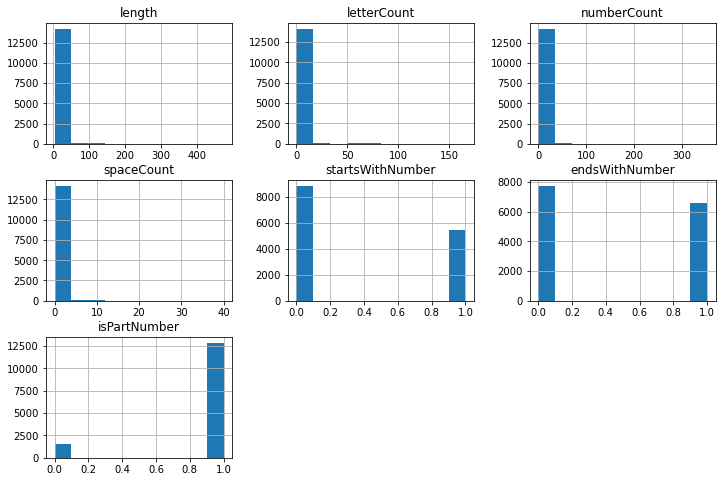

In [9]:
terms.hist(figsize=(12,8))

Above we can see that the length, number count, letter count, and space count are all right-skewed. Also of interest is that there are far more part number search terms in the dataset than keyword search terms. We may need to employ a method like oversampling or undersampling to ensure the best performance of our model.

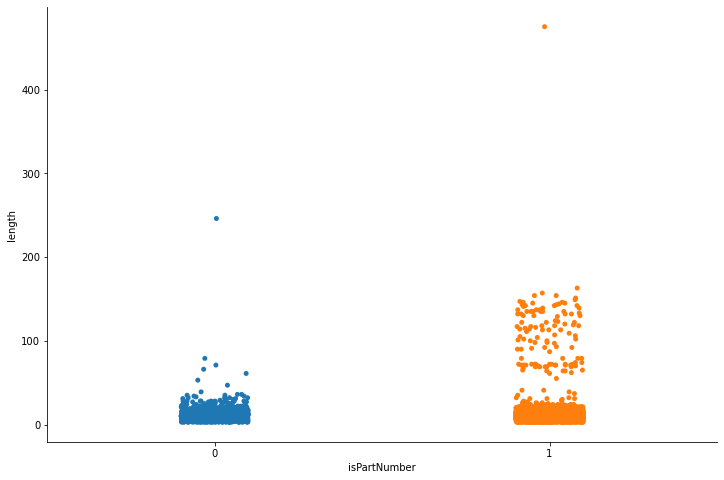

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

sns.stripplot(x='isPartNumber', y='length', data=terms)
sns.despine()

Aside from the fact that there is more isPartNumber=1 data, the distributions for the length of the search term look similar. Most keyword lengths are much less than 100 characters long. There are more outliers longer than 100 characters that are part numbers, however, which feels a little strange. Let's take a closer look at those values.

In [26]:
# long keyword terms
terms.loc[(terms['length'] > 50) & (terms['isPartNumber'] == 0), ['term', 'length', 'isPartNumber']].sample(5)

,term,length,isPartNumber
288,ipoe17195w industrial singleport multigigabit ...,66,0
368,745ttc838 solder tip 838soldering irons cartri...,79,0
359,processor i910900e 10th gen. processor ram 16g...,246,0
377,ethernet jack panelmount amphenol pn rcp5spffh...,53,0
408,1513 emre altunta megasan elektronik a.. 65756...,61,0


The long keyword search terms are not as surprising, since there are a lot of keywords you can include to describe a search for an electronic component. Will it yield a search with non-zero results? Maybe not, but it is still a legitimate search. Notice that some of the terms in the sample include part numbers, but since they also include non-part number words, they've been tagged as keyword searches, since you won't find this search term in a part number field on a result.

In [27]:
# long part number terms
terms.loc[(terms['length'] > 50) & (terms['isPartNumber'] == 1), ['term', 'length', 'isPartNumber']].sample(5)

,term,length,isPartNumber
3432,ADG411BRUZ SN65LVDS93ADGGR STW9N150 ADS7953SBR...,101,1
3751,AD8251ARMZR7 ADUM6402CRWZRL EP4CGX22CF19C8N LM...,144,1
4009,LMP91000SDENOPB MC9S12XET256MAG FSA1156P6X NCV...,70,1
3379,RCS040247K5FKED RCT0C RDER72J104K4K1H03B RE65G...,67,1
3919,LCMXO3L1300C5BG256C STM32F407VGT7 LMZ31707RVQR...,129,1


So it looks like these long part number search terms are strings of multiple part numbers searched at once. That explains why they're so long, yet are legitimate search terms.

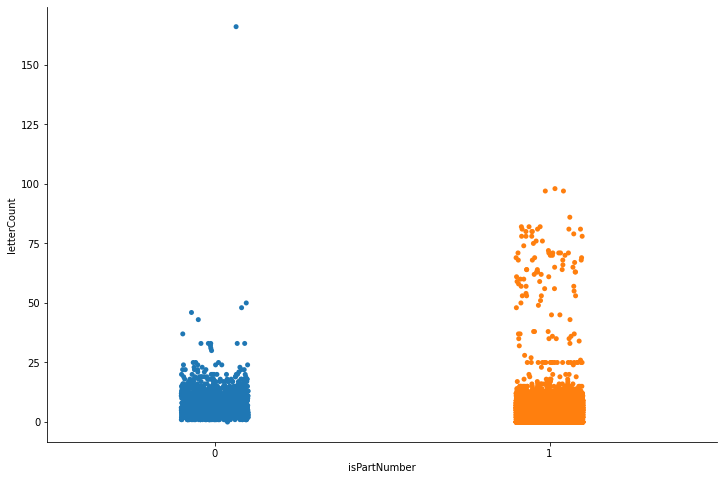

In [28]:
fig, ax = plt.subplots(figsize=(12,8))

sns.stripplot(x='isPartNumber', y='letterCount', data=terms)
sns.despine()

Interestingly enough, the part number search terms seem to be more likely to have a high count of letters. Still, most search terms in general have less than 25 letters in them.

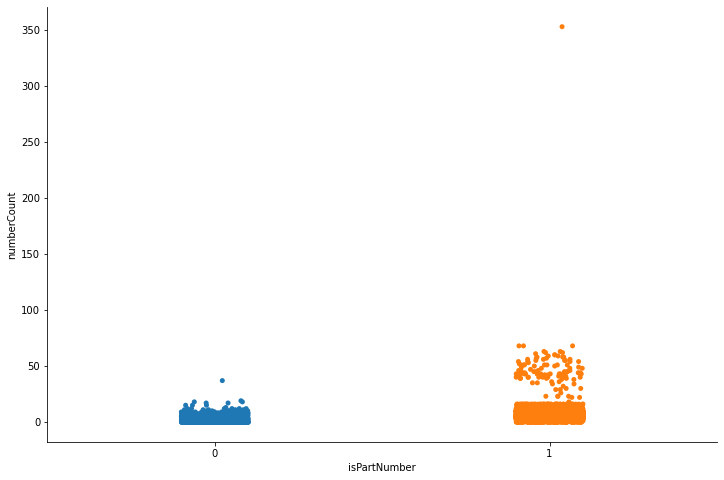

In [29]:
fig, ax = plt.subplots(figsize=(12,8))

sns.stripplot(x='isPartNumber', y='numberCount', data=terms)
sns.despine()

Unsurprisingly, the part number search terms have more terms with high counts of digits.

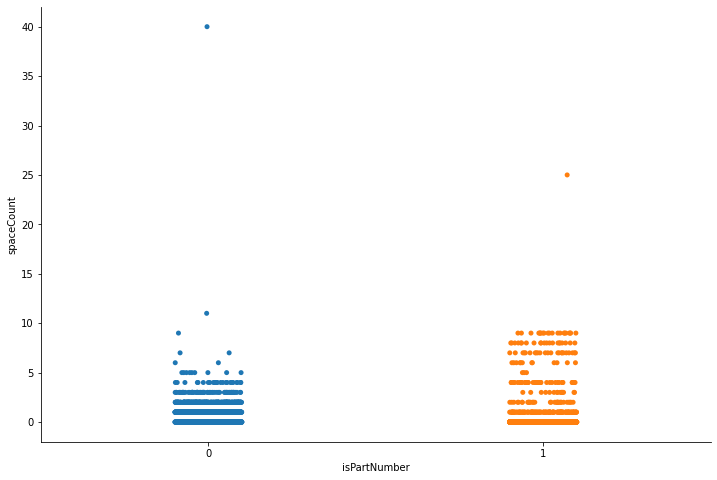

In [35]:
fig, ax = plt.subplots(figsize=(12,8))

sns.stripplot(x='isPartNumber', y='spaceCount', data=terms)
sns.despine()

There seem to be more spaces in part number search terms.

In [37]:
pd.crosstab(terms['startsWithNumber'], terms['isPartNumber'])

isPartNumber,0,1
startsWithNumber,,
0,717,8151
1,774,4715


Since it can be tough to see on a graph, this table gives us a better idea of how startsWithNumber relates to isPartNumber. Here we can see that a part number is more likely NOT to start with a number, which I admit feels counterintuitive, whereas for a keyword term the chances seem more 50-50.

In [38]:
pd.crosstab(terms['endsWithNumber'], terms['isPartNumber'])

isPartNumber,0,1
endsWithNumber,,
0,1367,6387
1,124,6479


On the other hand, a keyword term is more likely not to end with a number, while for a part number the chances of ending with a part number are more 50-50.

In [10]:
terms.corr() #correlation matrix for our columns

,length,letterCount,numberCount,spaceCount,startsWithNumber,endsWithNumber,isPartNumber
length,1.000000,0.871047,0.806896,0.790340,-0.128852,-0.131055,0.003598
letterCount,0.871047,1.000000,0.419127,0.705746,-0.424244,-0.382618,-0.130411
numberCount,0.806896,0.419127,1.000000,0.548931,0.223623,0.212874,0.232289
spaceCount,0.790340,0.705746,0.548931,1.000000,0.052644,-0.094224,-0.349531
startsWithNumber,-0.128852,-0.424244,0.223623,0.052644,1.000000,0.402199,-0.095826
endsWithNumber,-0.131055,-0.382618,0.212874,-0.094224,0.402199,1.000000,0.257336
isPartNumber,0.003598,-0.130411,0.232289,-0.349531,-0.095826,0.257336,1.000000


Our target variable, isPartNumber, seems to be most strongly correlated with two variables:
- spaceCount - negatively, which means as one increases, the other decreases, aka the higher the space count, the less likely the term is to be a part number, which does make intuitive sense
- endsWithNumber - positively, which means that as one increases, the other increases, aka if a term ends with a digit, it's more likely to be a part number search

# Model Data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, \
confusion_matrix, ConfusionMatrixDisplay

## Create training and test datasets

In [4]:
feature_columns = ['length', 'letterCount', 'numberCount', 'spaceCount', 'startsWithNumber', 'endsWithNumber']
X = terms[feature_columns]
y = terms['isPartNumber']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
print(X.shape)
print(y.shape)

(14357, 6)
(14357,)


In [16]:
print(X_train.shape)
print(y_train.shape)

(11485, 6)
(11485,)


In [17]:
print(X_test.shape)
print(y_test.shape)

(2872, 6)
(2872,)


## Linear SVC

In [5]:
from sklearn.svm import LinearSVC

### Initial model

In [6]:
# set dual=False (selecting optimization) because recommended when n_samples > n_features
model_lsvc = LinearSVC(penalty='l2', dual=False)
model_lsvc.fit(X_train, y_train) # train model

LinearSVC(dual=False)

In [7]:
y_pred_lsvc = model_lsvc.predict(X_test)

In [8]:
print("Accuracy: ", accuracy_score(y_test, y_pred_lsvc))
print("Precision: ", precision_score(y_test, y_pred_lsvc))
print("Recall: ", recall_score(y_test, y_pred_lsvc))

Accuracy:  0.9697075208913649
Precision:  0.9749240121580547
Recall:  0.9918824893699265


These are really great scores. Our model is right in general 96% of the time. When the model predicts that a term is a part number, it is right 97% of the time. When a term is a part number, the model predicts the correct label 99% of the time.

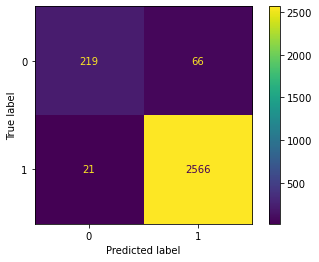

In [9]:
cf_matrix = confusion_matrix(y_test, y_pred_lsvc, labels=model_lsvc.classes_)
display = ConfusionMatrixDisplay(cf_matrix, display_labels=model_lsvc.classes_)
display.plot()
plt.show()

Here we can see that the model is significantly stronger at predicting part number search terms. They do make up the most of the dataset. But the model did also correctly predict a majority of the keyword search terms.

In [10]:
print(classification_report(y_test, y_pred_lsvc))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       285
           1       0.97      0.99      0.98      2587

    accuracy                           0.97      2872
   macro avg       0.94      0.88      0.91      2872
weighted avg       0.97      0.97      0.97      2872



This report gives us a clearer view of how the model did on the "negative" class, the non-part number search terms. When the model predicted a term was a non-part number search, it was right 91% of the time. When a term actually was a keyword search, the model predicted the correct label only 77% of the time. This lower score may not be a big problem, but given that it's more helpful to distinguish non-part number searches, we do want that score to be a little higher.

### Model tuning

We can try to tune this model by addressing the class imbalance.

In [11]:
# class_weight='balanced' will adjust regularization weights based off of class frequencies
lsvc_2 = LinearSVC(penalty='l2', dual=False, class_weight='balanced')
lsvc_2.fit(X_train, y_train)

LinearSVC(class_weight='balanced', dual=False)

In [12]:
y_pred_lsvc_2 = lsvc_2.predict(X_test)

In [13]:
print("Accuracy: ", accuracy_score(y_test, y_pred_lsvc_2))
print("Precision: ", precision_score(y_test, y_pred_lsvc_2))
print("Recall: ", recall_score(y_test, y_pred_lsvc_2))

Accuracy:  0.9592618384401114
Precision:  0.9991915925626516
Recall:  0.9555469655972169


High scores again. Higher precision this time (more correct predictions when it predicts part number) and lower recall (slightly fewer correct guesses when the term actually is a part number), but still high overall.

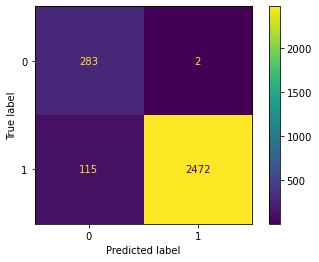

In [14]:
cf_matrix_2 = confusion_matrix(y_test, y_pred_lsvc_2, labels=lsvc_2.classes_)
display_2 = ConfusionMatrixDisplay(cf_matrix_2, display_labels=lsvc_2.classes_)
display_2.plot()
plt.show()

Fewer incorrect predictions on the keyword class! More incorrect predictions on the part number class, but only slightly, which is what the recall score told us.

In [15]:
print(classification_report(y_test, y_pred_lsvc_2))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       285
           1       1.00      0.96      0.98      2587

    accuracy                           0.96      2872
   macro avg       0.86      0.97      0.90      2872
weighted avg       0.97      0.96      0.96      2872



Here we can see a tradeoff between precision and recall on the negative (keyword) class. This model predicts a keyword search to be a keyword search 99% of the time, but when it predicts keyword search, it is only correct 71% of the time.

Although we know that there is a natural tradeoff between precision and recall, such that it is difficult to get both to be high, let's try another model to see if we can achieve a better balance between the two.

## Radius Nearest Neighbors

Since our data has some skew in that there are much more part number terms than non-part number terms, we will use radius nearest neighbors in an attempt to offset that by looking at fewer neighbors when classifying each point.

In [37]:
from sklearn.neighbors import RadiusNeighborsClassifier

### Initial model

In [54]:
# starting with a radius of 3, and labelling outliers with the most frequent label of y, which will be 1 for part number search
rnn = RadiusNeighborsClassifier(radius=3.0, outlier_label='most_frequent')
rnn.fit(X_train, y_train)

RadiusNeighborsClassifier(outlier_label='most_frequent', radius=3.0)

In [55]:
y_pred_rnn = rnn.predict(X_test)

In [56]:
print("Accuracy: ", accuracy_score(y_test, y_pred_rnn))
print("Precision: ", precision_score(y_test, y_pred_rnn))
print("Recall: ", recall_score(y_test, y_pred_rnn))

Accuracy:  0.9341922005571031
Precision:  0.938484071768583
Recall:  0.9918730650154799


Again, high scores, especially on recall. Accuracy is lower than on our linear SVC model, and so is precision when predicting a label of part number.

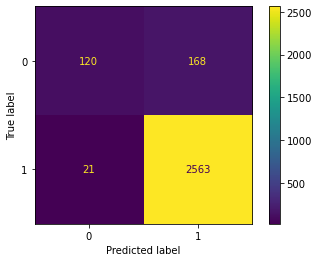

In [57]:
cm_rnn = confusion_matrix(y_test, y_pred_rnn, labels=rnn.classes_)
display = ConfusionMatrixDisplay(cm_rnn, display_labels=rnn.classes_)
display.plot()
plt.show()

Here we can see a lot more incorrectly predicted keyword search terms, perhaps thanks in part to those outliers.

In [58]:
print(classification_report(y_test, y_pred_rnn))

              precision    recall  f1-score   support

           0       0.85      0.42      0.56       288
           1       0.94      0.99      0.96      2584

    accuracy                           0.93      2872
   macro avg       0.89      0.70      0.76      2872
weighted avg       0.93      0.93      0.92      2872



Here we can see very low recall on the keyword search class, and much lower precision than the linear SVC model. 

### Model tuning

In [59]:
rnn_trial = RadiusNeighborsClassifier(radius=10.0)
rnn_trial.fit(X_train, y_train)
y_pred_rnn_trial = rnn_trial.predict(X_test)

ValueError: No neighbors found for test samples array([ 71, 181, 878], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.

We could try to search for the best radius value, but above we can see that without forcing our outliers to some label, even a large radius leaves a handful of outliers without enough neighbors to assign a label. This may be defeating the purpose of choosing this model so that we can work with less neighbors because of the skew of the dataset.

In [61]:
rnn_5 = RadiusNeighborsClassifier(radius=5.0, outlier_label='most_frequent')
rnn_5.fit(X_train, y_train)
y_pred_rnn_5 = rnn_5.predict(X_test)
print(classification_report(y_test, y_pred_rnn_5))

              precision    recall  f1-score   support

           0       0.82      0.16      0.26       288
           1       0.91      1.00      0.95      2584

    accuracy                           0.91      2872
   macro avg       0.87      0.58      0.61      2872
weighted avg       0.90      0.91      0.88      2872



In [62]:
rnn_10 = RadiusNeighborsClassifier(radius=10.0, outlier_label='most_frequent')
rnn_10.fit(X_train, y_train)
y_pred_rnn_10 = rnn_10.predict(X_test)
print(classification_report(y_test, y_pred_rnn_10))

              precision    recall  f1-score   support

           0       0.67      0.03      0.07       288
           1       0.90      1.00      0.95      2584

    accuracy                           0.90      2872
   macro avg       0.78      0.52      0.51      2872
weighted avg       0.88      0.90      0.86      2872



And as we can see, our scores seem to weaken as the radius widens, so it looks like this model is not the best one for our data.

# Analysis

## Investigating Incorrect Predictions

Let's compare the test dataset with its actual labels and its predicted labels from our two Linear SVC models so we can see the actual terms alongside their predictions.

In [16]:
terms_with_preds = terms.loc[X_test.index.tolist()]
terms_with_preds['isPartNumber_pred_lsvc1'] = y_pred_lsvc.tolist()
terms_with_preds['isPartNumber_pred_lsvc2'] = y_pred_lsvc_2.tolist()
terms_with_preds.head()

,term,length,letterCount,numberCount,spaceCount,startsWithNumber,endsWithNumber,isPartNumber,isPartNumber_pred_lsvc1,isPartNumber_pred_lsvc2
6520,adm631531d2artzr7,17,9,8,0,0,1,1,1,1
2672,2000415533,10,0,10,0,1,1,1,1,1
288,ipoe17195w industrial singleport multigigabit ...,66,50,9,6,0,0,0,0,0
8296,10M02SCU324C8GNW,16,8,8,0,1,0,1,1,1
8917,TMS320F240,10,4,6,0,0,1,1,1,1


In [17]:
prediction_columns = ['term', 'isPartNumber', 'isPartNumber_pred_lsvc1', 'isPartNumber_pred_lsvc2']
wrong_predictions = terms_with_preds[(terms_with_preds.isPartNumber != terms_with_preds.isPartNumber_pred_lsvc1) | (terms_with_preds.isPartNumber != terms_with_preds.isPartNumber_pred_lsvc2)][prediction_columns]

In [18]:
wrong_predictions.shape

(181, 4)

In [80]:
wrong_predictions

,term,isPartNumber,isPartNumber_pred_lsvc1,isPartNumber_pred_lsvc2
474,0 501 324 622 a,1,0,0
914,0.9pf 0805,0,1,0
10007,pesd1can,1,1,0
12287,pcie,1,1,0
8501,22UF 10v 0805,0,1,0
...,...,...,...,...
7123,nhd5.0hdmin,1,1,0
883,0.68r,1,0,0
6664,iis2mdctr,1,1,0
912,0.9pf 0201,0,1,0


### Base Linear SVC Model

#### Part numbers the model thought were keywords

In [23]:
wrong_partnumbers_lsvc1 = wrong_predictions[(wrong_predictions.isPartNumber == 1) & (wrong_predictions.isPartNumber_pred_lsvc1 == 0)]

In [25]:
wrong_partnumbers_lsvc1

,term,isPartNumber,isPartNumber_pred_lsvc1,isPartNumber_pred_lsvc2
13225,5csx,1,0,0
5449,bp xxx.,1,0,0
5614,xbibcgps,1,0,0
6804,mtfc4gacaana4m it,1,0,0
13624,5cseba,1,0,0
6686,cppfxt7bdxxx.xxxxxxpd,1,0,0
915,00 8263 03 11 00 000,1,0,0
13249,jst xh,1,0,0
5512,xbibcmmt,1,0,0
1246,010 01 25 212 056,1,0,0


#### Keywords the model thought were part numbers

In [26]:
wrong_keywords_lsvc1 = wrong_predictions[(wrong_predictions.isPartNumber == 0) & (wrong_predictions.isPartNumber_pred_lsvc1 == 1)]

In [27]:
wrong_keywords_lsvc1

,term,isPartNumber,isPartNumber_pred_lsvc1,isPartNumber_pred_lsvc2
11109,rohs,0,1,0
9395,ldo,0,1,0
12259,adapter,0,1,0
628,0.075uf,0,1,0
9927,fet,0,1,0
...,...,...,...,...
10313,quartz,0,1,0
2230,0402 10uf,0,1,0
7888,peltier,0,1,0
9708,speaker,0,1,0


Some of these are surprising. For example, there are terms that are all numbers that were predicted as non-part number searches and terms that are all letters that were predicted as part number searches. All letters = non-part number and all numbers = part number seems like a simple rule to learn, but remember than this model is drawing a plane between the two classes. 

### Linear SVC Model with class balancing

#### Part numbers the model thought were keywords

In [28]:
wrong_partnumbers_lsvc2 = wrong_predictions[(wrong_predictions.isPartNumber == 1) & (wrong_predictions.isPartNumber_pred_lsvc2 == 0)]

In [29]:
wrong_partnumbers_lsvc2

,term,isPartNumber,isPartNumber_pred_lsvc1,isPartNumber_pred_lsvc2
13225,5csx,1,0,0
9655,eeprom,1,1,0
9451,tvs,1,1,0
10958,smbj5.0ca,1,1,0
9727,i2c,1,1,0
...,...,...,...,...
6333,nhd7.0ctpcapen,1,1,0
1489,02sabf2.2pfhq,1,0,0
6447,itpspsik,1,0,0
1460,02 02 160 2301,1,1,0


#### Keywords the model thought were part numbers

In [30]:
wrong_keywords_lsvc2 = wrong_predictions[(wrong_predictions.isPartNumber == 0) & (wrong_predictions.isPartNumber_pred_lsvc2 == 1)]

In [31]:
wrong_keywords_lsvc2

,term,isPartNumber,isPartNumber_pred_lsvc1,isPartNumber_pred_lsvc2
402,mouser 279yr1b49r9cc,0,1,1
604,0.047uf 0805,0,1,1


## Predicting on new data

In [67]:
import numpy as np
from generate_keyword_data import generateSearchTermData

In [77]:
# function takes a search term and it's true class, runs it through the model, and compares the prediction to true value
def predict_search_term(term, isPartNumber):
    p = ''
    X = generateSearchTermData(term) # get feature column data for this term
    X.pop(0) # remove term from feature column data
    X.pop() # remove empty space for isPartNumber
    if len(X) == len(feature_columns):
        X = np.array(X, dtype=int).reshape(1, -1) # reshape to 2D array
        pred_lsvc1 = model_lsvc.predict(X)
        p += f'The base model predicted {"correctly" if pred_lsvc1[0] == isPartNumber else "incorrectly"}! '
        pred_lsvc2 = lsvc_2.predict(X)
        p += f'The balanced model predicted {"correctly" if pred_lsvc2[0] == isPartNumber else "incorrectly"}!'
        return p
    return "Error: invalid search term data returned"

In [76]:
print(predict_search_term("usb 3.0", 0)) # not a part number search

The base model predicted correctly! The balanced model predicted correctly! 


In [78]:
print(predict_search_term("22UF", 0)) #not a part number search

The base model predicted correctly! The balanced model predicted correctly!


In [79]:
print(predict_search_term("200mm", 0)) # not a part number search

The base model predicted incorrectly! The balanced model predicted correctly!


In [80]:
print(predict_search_term("23uf", 0)) # not a part number search

The base model predicted correctly! The balanced model predicted correctly!


In [81]:
print(predict_search_term("100cm", 0)) # not a part number search

The base model predicted incorrectly! The balanced model predicted correctly!


In [82]:
print(predict_search_term("800v", 0)) # not a part number search

The base model predicted incorrectly! The balanced model predicted correctly!


In [83]:
print(predict_search_term("mt10", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


In [84]:
print(predict_search_term("ddr5", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


In [85]:
print(predict_search_term("ddr3", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


In [86]:
print(predict_search_term("q200", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


In [87]:
print(predict_search_term("700icm7555ipa", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


In [88]:
print(predict_search_term("2n2222a", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


In [89]:
print(predict_search_term("2n2222", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


In [90]:
print(predict_search_term("1590b", 1)) # part number search

The base model predicted correctly! The balanced model predicted correctly!


# Conclusion & Save Model

I'd like to move forward with the balanced model since it is specifically built to handle imbalanced data, which is what the production search term data looks like. Let's save and export the model.

In [91]:
# save to pickle
import pickle
pickle.dump(lsvc_2, open("keyword_partnumber_classmodel.pickle", "wb"))

In [1]:
# save vectorizer method to pickle
from generate_keyword_data import generateSearchTermData
import pickle
pickle.dump(generateSearchTermData, open("generate-term-data.pickle", "wb"))